<a href="https://colab.research.google.com/github/MDIL-SNU/SevenNet/blob/tutorial/tutorial/SevenNet_python_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SevenNet tutorial: python interactive
---
This notebook is a python interactive tutorial for SevenNet.\
[paper](https://pubs.acs.org/doi/10.1021/acs.jctc.4c00190)\
[code](https://github.com/MDIL-SNU/SevenNet) \
We recommend using a GPU. If you're using Colab,\
[Runtime] -> [Change runtime type] -> [T4 GPU] -> [Save]

If the notebook crashes, restart the notebook. If you're using Colab, \
[Runtime] -> [Disconnect and delete runtime] -> restart!

## 0. Installation
First of all, let's install SevenNet to our computer!

In [1]:
# Install SevenNet
!pip install sevenn

# If you want to check the SevenNet code, clone the repo.
# !git clone https://github.com/MDIL-SNU/SevenNet.git 

import os
working_dir = os.getcwd() # save current path

In [2]:
# check if sevenn is installed well
!sevenn -h

usage: sevenn [-h] [-m {train_v1,train_v2}] [-w [WORKING_DIR]] [-l LOG] [-s]
              [-d] [--distributed_backend {nccl,mpi}]
              input_yaml

sevenn version=0.10.0, train model based on the input.yaml

positional arguments:
  input_yaml            input.yaml for training

optional arguments:
  -h, --help            show this help message and exit
  -m {train_v1,train_v2}, --mode {train_v1,train_v2}
                        main training script to run. Default is train.
  -w [WORKING_DIR], --working_dir [WORKING_DIR]
                        path to write output. Default is cwd.
  -l LOG, --log LOG     name of logfile, default is log.sevenn
  -s, --screen          print log to stdout
  -d, --distributed     set this flag if it is distributed training
  --distributed_backend {nccl,mpi}
                        backend for distributed training. Supported: nccl, mpi


## 1. Dataset

In [3]:
# download the dataset
!pip install gdown
!gdown https://drive.google.com/uc?id=1TZPJzJaaBPZIiD5gaHC7E0oDngN14rJg

Downloading...
From (original): https://drive.google.com/uc?id=1TZPJzJaaBPZIiD5gaHC7E0oDngN14rJg
From (redirected): https://drive.google.com/uc?id=1TZPJzJaaBPZIiD5gaHC7E0oDngN14rJg&confirm=t&uuid=19673f21-08cf-4d34-9f3c-67348af5bbe1
To: /home/hexagonrose/SevenNet/tutorial/seven_tuto_data.zip
100%|████████████████████████████████████████| 440M/440M [00:27<00:00, 16.0MB/s]


In [4]:
!unzip seven_tuto_data.zip

Archive:  seven_tuto_data.zip
   creating: evaluation/
  inflating: evaluation/eos.extxyz   
  inflating: evaluation/test_md.extxyz  
   creating: train/
   creating: train/1200K/
  inflating: train/1200K/OUTCAR      
   creating: train/600K/
  inflating: train/600K/OUTCAR       


In [5]:
# write structure_list file
# You can increase the data. For example, 150:1000:1

with open('structure_list', 'w') as f:
    f.write('[MD_1200K]\n')
    f.write(f'{working_dir}/train/1200K/OUTCAR 150:1000:10')
    f.write('\n')
    f.write('[MD_600K]\n')
    f.write(f'{working_dir}/train/600K/OUTCAR 150:1000:10')


## 2. Training from scratch

In [6]:
# let's read dataset and make a dataloader!
import os
working_dir = os.getcwd() # save current path
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm # for epoch log
import torch

# for data
from ase.io import read
from sevenn.train.dataset import AtomGraphDataset
from sevenn.train.graph_dataset import SevenNetGraphDataset
from torch_geometric.loader import DataLoader # for dataloader
from sevenn.train.dataload import file_to_dataset, match_reader, graph_build

# for training
from sevenn.model_build import build_E3_equivariant_model # for model
from sevenn.sevenn_logger import Logger # for log while training
from sevenn.train.loss import PerAtomEnergyLoss, ForceLoss, StressLoss
# util
import sevenn._keys as KEY
import sevenn.util as util

# hyperparameters
cutoff=5.0
num_workers=4
num_epoch=50  # If you want an R²value of around 0.98, run the model for 150 epochs.
device='cuda'
lr=0.005
gamma=0.99
energy_loss_weight=1
force_loss_weight=0.1
stress_loss_weight=1e-6

### Dataset setting

In [7]:
dataset_path = os.path.join(working_dir, 'structure_list')
dataset = SevenNetGraphDataset(files=dataset_path, root=working_dir, processed_name='train.pt',
                               cutoff=cutoff, process_num_cores=num_workers) # it takes about 1 min

num_dataset = len(dataset)
num_train = int(num_dataset*0.8)
num_valid = int(num_dataset*0.1)
num_test = int(num_dataset*0.1)

# split the dataset into train & valid
dataset = dataset.shuffle()
train_dataset = dataset[:num_train]
valid_dataset = dataset[num_train:num_train+num_valid]
test_dataset = dataset[num_train+num_valid:]
print(f'Total dataset: {num_dataset}')
print(f'Dataset for training: {len(train_dataset)}')
print(f'Dataset for validation: {len(valid_dataset)}')
print(f'Dataset for test: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=10, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=10, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=10, num_workers=num_workers)

Processing...
graph_build (4): 100%|██████████| 85/85 [00:03<00:00, 27.79it/s]
Done!
run_stat: 100%|██████████| 170/170 [00:00<00:00, 1570.43it/s]

Total dataset: 170
Dataset for training: 136
Dataset for validation: 17
Dataset for test: 17


### Model setting

In [8]:
train_shift = train_dataset.per_atom_energy_std
train_scale = train_dataset.force_rms
train_conv_denominator = train_dataset.avg_num_neigh
model_setting = {
  'cutoff': cutoff,
  '_number_of_species': 'auto',
  'channel': 32,
  'num_convolution_layer': 3,
  'interaction_type': 'nequip',
  'use_bias_in_linear': False,
  'lmax': 1,
  'lmax_edge': -1,
  'lmax_node': -1,
  'act_radial': 'silu',
  'self_connection_type': 'nequip',
  'irreps_manual': False,
  'conv_denominator': train_conv_denominator,
  'shift': train_shift,
  'scale': train_scale,
  'train_denominator': False,
  'radial_basis': {'radial_basis_name': 'bessel'},
  'cutoff_function': {'cutoff_function_name': 'poly_cut'},
  'is_parity': True,
  '_normalize_sph': True,
  'weight_nn_hidden_neurons': [64, 64],
  'act_scalar': {'e': 'silu', 'o': 'tanh'},
  'act_gate': {'e': 'silu', 'o': 'tanh'},
  'readout_as_fcn': False,
  'train_shift_scale': False,
}
model_setting.update(util.chemical_species_preprocess([], universal=True)) # for element update

model = build_E3_equivariant_model(model_setting)
print(model) # model info

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): PolynomialCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(119x0e -> 32x0e | 3808 weights)
  )
  (0_self_connection_intro): SelfConnectionIntro(
    (fc_tensor_product): FullyConnectedTensorProduct(32x0e x 119x0e -> 64x0e+32x1o | 243712 paths | 243712 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(32x0e -> 32x0e | 1024 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(32x0e x 1x0e+1x1o -> 32x0e+32x1o | 64 paths | 64 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 64]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(32x0e+32x1o -> 64x0e+32x1o | 3072 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivariant_gate): EquivariantGat

### Start training
If you want more accurate model, increase the num_epoch!

In [9]:
model.to(device)

# define optimizer
params = [p for _, p in model.named_parameters() if p.requires_grad] # parameters to change
optimizer = torch.optim.Adam(params, lr=lr) # optimizer for training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma) # lr scheduler for effective training

# define loss functions
loss_criterion = torch.nn.MSELoss()
loss_functions = []
loss_functions.append((PerAtomEnergyLoss(), energy_loss_weight)) # energy loss
loss_functions.append((ForceLoss(), force_loss_weight)) # force loss
# you can add stress loss if you want.
# loss_functions.append((StressLoss(), stress_loss_weight))
for loss_function, _ in loss_functions:
  if loss_function.criterion is None:
      loss_function.assign_criteria(loss_criterion)

# Define variables for tracking the best validation loss
best_valid_loss = float('inf')  # Initialize to a very large value
best_checkpoint = None  # To store the best model state

# Training start
os.makedirs('checkpoint', exist_ok=True)
for epoch in range(1, num_epoch+1):
  model.train()
  print(f'epoch: {epoch}')
  # Training step
  for step, batch in tqdm(enumerate(iter(train_loader))):
    batch.to(device)  # connect batch to gpu
    optimizer.zero_grad()

    # print('ans: ', batch.per_atom_energy)
    output = model(batch)
    # print('pred: ', output.per_atom_energy)

    # calculate loss
    train_loss = torch.zeros(1, device=device)
    for loss_def, w in loss_functions:
      train_loss += loss_def.get_loss(output, model) * w

    # update
    train_loss.backward()
    optimizer.step()

  # Validation step
  model.eval()
  valid_loss = torch.zeros(1, device=device)
  for step, batch in tqdm(enumerate(iter(valid_loader))):
    batch.to(device)
    output = model(batch)

    for loss_def, w in loss_functions:
      valid_loss += loss_def.get_loss(output, model) * w
  valid_loss /= len(valid_loader)

  # print loss
  print()
  print(f'Train loss: {train_loss.item():.4f}')
  print(f'Valid loss: {valid_loss.item():.4f}')
  print('----------------------------------------------')

  # update lr using scheduler
  scheduler.step()

  # save the model
  if epoch % 5 == 0: # Save checkpoint per 5 epochs. You can adjust this.
    cp = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(cp, f'checkpoint/checkpoint_{epoch:02d}.pt')

  # check if this is the best validation loss
  if valid_loss.item() < best_valid_loss:
    best_valid_loss = valid_loss.item()
    best_checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    # Save the best checkpoint
    torch.save(best_checkpoint, 'checkpoint/checkpoint_best.pt')

print(f'Best model saved with validation loss: {best_valid_loss:.4f}')

epoch: 1


14it [00:04,  2.95it/s]
2it [00:00,  8.13it/s]


Train loss: 16.3706
Valid loss: 16.6733
----------------------------------------------
epoch: 2



14it [00:03,  4.16it/s]
2it [00:00,  7.20it/s]


Train loss: 16.3624
Valid loss: 16.6637
----------------------------------------------
epoch: 3



14it [00:03,  3.92it/s]
2it [00:00,  8.38it/s]


Train loss: 16.2769
Valid loss: 16.5580
----------------------------------------------
epoch: 4



14it [00:03,  3.96it/s]
2it [00:00,  6.70it/s]


Train loss: 14.5828
Valid loss: 14.4083
----------------------------------------------
epoch: 5



14it [00:03,  4.02it/s]
2it [00:00,  8.66it/s]


Train loss: 6.0547
Valid loss: 4.8905
----------------------------------------------
epoch: 6



14it [00:03,  4.39it/s]
2it [00:00,  8.47it/s]


Train loss: 2.2210
Valid loss: 2.0172
----------------------------------------------
epoch: 7



14it [00:03,  3.81it/s]
2it [00:00,  7.39it/s]


Train loss: 1.1002
Valid loss: 1.0312
----------------------------------------------
epoch: 8



14it [00:03,  4.34it/s]
2it [00:00,  6.95it/s]


Train loss: 0.6343
Valid loss: 0.5630
----------------------------------------------
epoch: 9



14it [00:03,  4.25it/s]
2it [00:00,  8.17it/s]


Train loss: 0.3927
Valid loss: 0.3593
----------------------------------------------
epoch: 10



14it [00:03,  4.61it/s]
2it [00:00,  9.71it/s]


Train loss: 0.2523
Valid loss: 0.2333
----------------------------------------------
epoch: 11



14it [00:03,  4.55it/s]
2it [00:00,  6.88it/s]


Train loss: 0.1670
Valid loss: 0.1547
----------------------------------------------
epoch: 12



14it [00:03,  4.38it/s]
2it [00:00,  6.89it/s]


Train loss: 0.1165
Valid loss: 0.1057
----------------------------------------------
epoch: 13



14it [00:03,  4.40it/s]
2it [00:00,  8.99it/s]


Train loss: 0.0844
Valid loss: 0.0738
----------------------------------------------
epoch: 14



14it [00:03,  4.60it/s]
2it [00:00,  8.28it/s]


Train loss: 0.0671
Valid loss: 0.0552
----------------------------------------------
epoch: 15



14it [00:02,  4.72it/s]
2it [00:00, 10.01it/s]


Train loss: 0.0604
Valid loss: 0.0467
----------------------------------------------
epoch: 16



14it [00:03,  4.63it/s]
2it [00:00,  7.36it/s]


Train loss: 0.0577
Valid loss: 0.0431
----------------------------------------------
epoch: 17



14it [00:02,  4.77it/s]
2it [00:00,  9.54it/s]


Train loss: 0.0561
Valid loss: 0.0411
----------------------------------------------
epoch: 18



14it [00:02,  4.89it/s]
2it [00:00,  9.60it/s]


Train loss: 0.0549
Valid loss: 0.0398
----------------------------------------------
epoch: 19



14it [00:03,  4.14it/s]
2it [00:00,  8.21it/s]


Train loss: 0.0541
Valid loss: 0.0389
----------------------------------------------
epoch: 20



14it [00:03,  4.45it/s]
2it [00:00,  8.05it/s]


Train loss: 0.0535
Valid loss: 0.0382
----------------------------------------------
epoch: 21



14it [00:03,  4.30it/s]
2it [00:00,  7.59it/s]


Train loss: 0.0529
Valid loss: 0.0376
----------------------------------------------
epoch: 22



14it [00:03,  4.65it/s]
2it [00:00,  8.11it/s]


Train loss: 0.0523
Valid loss: 0.0370
----------------------------------------------
epoch: 23



14it [00:02,  4.80it/s]
2it [00:00,  8.10it/s]


Train loss: 0.0516
Valid loss: 0.0365
----------------------------------------------
epoch: 24



14it [00:03,  4.47it/s]
2it [00:00,  8.65it/s]


Train loss: 0.0507
Valid loss: 0.0358
----------------------------------------------
epoch: 25



14it [00:02,  4.74it/s]
2it [00:00,  8.51it/s]


Train loss: 0.0497
Valid loss: 0.0351
----------------------------------------------
epoch: 26



14it [00:03,  4.40it/s]
2it [00:00,  9.08it/s]


Train loss: 0.0484
Valid loss: 0.0342
----------------------------------------------
epoch: 27



14it [00:02,  4.78it/s]
2it [00:00,  8.41it/s]


Train loss: 0.0466
Valid loss: 0.0331
----------------------------------------------
epoch: 28



14it [00:03,  4.62it/s]
2it [00:00,  9.30it/s]


Train loss: 0.0441
Valid loss: 0.0316
----------------------------------------------
epoch: 29



14it [00:03,  4.38it/s]
2it [00:00,  6.84it/s]


Train loss: 0.0405
Valid loss: 0.0295
----------------------------------------------
epoch: 30



14it [00:03,  4.33it/s]
2it [00:00,  8.95it/s]


Train loss: 0.0356
Valid loss: 0.0269
----------------------------------------------
epoch: 31



14it [00:03,  4.25it/s]
2it [00:00,  8.49it/s]


Train loss: 0.0329
Valid loss: 0.0252
----------------------------------------------
epoch: 32



14it [00:02,  4.75it/s]
2it [00:00,  9.41it/s]


Train loss: 0.0313
Valid loss: 0.0240
----------------------------------------------
epoch: 33



14it [00:02,  4.86it/s]
2it [00:00,  8.56it/s]


Train loss: 0.0302
Valid loss: 0.0233
----------------------------------------------
epoch: 34



14it [00:03,  4.57it/s]
2it [00:00,  8.94it/s]


Train loss: 0.0295
Valid loss: 0.0228
----------------------------------------------
epoch: 35



14it [00:02,  4.95it/s]
2it [00:00,  9.54it/s]


Train loss: 0.0289
Valid loss: 0.0223
----------------------------------------------
epoch: 36



14it [00:02,  4.96it/s]
2it [00:00,  9.56it/s]


Train loss: 0.0283
Valid loss: 0.0218
----------------------------------------------
epoch: 37



14it [00:02,  4.87it/s]
2it [00:00,  9.73it/s]


Train loss: 0.0277
Valid loss: 0.0214
----------------------------------------------
epoch: 38



14it [00:02,  4.98it/s]
2it [00:00, 10.23it/s]



Train loss: 0.0272
Valid loss: 0.0210
----------------------------------------------
epoch: 39


14it [00:02,  4.94it/s]
2it [00:00,  9.72it/s]


Train loss: 0.0267
Valid loss: 0.0207
----------------------------------------------
epoch: 40



14it [00:02,  4.95it/s]
2it [00:00, 10.00it/s]


Train loss: 0.0262
Valid loss: 0.0203
----------------------------------------------
epoch: 41



14it [00:02,  5.06it/s]
2it [00:00,  8.32it/s]


Train loss: 0.0257
Valid loss: 0.0199
----------------------------------------------
epoch: 42



14it [00:02,  5.01it/s]
2it [00:00,  9.15it/s]


Train loss: 0.0253
Valid loss: 0.0196
----------------------------------------------
epoch: 43



14it [00:02,  5.04it/s]
2it [00:00,  9.20it/s]


Train loss: 0.0249
Valid loss: 0.0192
----------------------------------------------
epoch: 44



14it [00:02,  5.02it/s]
2it [00:00,  9.39it/s]


Train loss: 0.0244
Valid loss: 0.0188
----------------------------------------------
epoch: 45



14it [00:02,  4.79it/s]
2it [00:00,  8.02it/s]


Train loss: 0.0240
Valid loss: 0.0185
----------------------------------------------
epoch: 46



14it [00:03,  4.01it/s]
2it [00:00,  9.38it/s]


Train loss: 0.0236
Valid loss: 0.0181
----------------------------------------------
epoch: 47



14it [00:03,  4.26it/s]
2it [00:00,  8.12it/s]


Train loss: 0.0233
Valid loss: 0.0178
----------------------------------------------
epoch: 48



14it [00:02,  4.94it/s]
2it [00:00,  8.77it/s]


Train loss: 0.0230
Valid loss: 0.0176
----------------------------------------------
epoch: 49



14it [00:03,  4.40it/s]
2it [00:00,  9.90it/s]


Train loss: 0.0226
Valid loss: 0.0173
----------------------------------------------
epoch: 50



14it [00:02,  4.77it/s]
2it [00:00,  8.86it/s]


Train loss: 0.0224
Valid loss: 0.0172
----------------------------------------------
Best model saved with validation loss: 0.0172


## 3. Model test
### Energy / force plot

In [10]:
# load test model
checkpoint = torch.load(f'checkpoint/checkpoint_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): PolynomialCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(119x0e -> 32x0e | 3808 weights)
  )
  (0_self_connection_intro): SelfConnectionIntro(
    (fc_tensor_product): FullyConnectedTensorProduct(32x0e x 119x0e -> 64x0e+32x1o | 243712 paths | 243712 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(32x0e -> 32x0e | 1024 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(32x0e x 1x0e+1x1o -> 32x0e+32x1o | 64 paths | 64 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 64]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(32x0e+32x1o -> 64x0e+32x1o | 3072 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivariant_gate): EquivariantGat

In [11]:
train_ans_energy = train_dataset.per_atom_energy
train_ans_force = train_dataset.force_of_atoms
train_pred_energy = []
train_pred_force = []

test_ans_energy = test_dataset.per_atom_energy
test_ans_force = test_dataset.force_of_atoms
test_pred_energy = []
test_pred_force = []

for step, batch in tqdm(enumerate(iter(train_loader))):
  batch.to(device)
  output = model(batch)
  train_pred_energy.append(output.inferred_total_energy/output.num_atoms)
  train_pred_force.append(output.inferred_force)

for step, batch in tqdm(enumerate(iter(test_loader))):
  batch.to(device)
  output = model(batch)
  test_pred_energy.append(output.inferred_total_energy/output.num_atoms)
  test_pred_force.append(output.inferred_force)

train_pred_energy = torch.cat(train_pred_energy, dim=0)
train_pred_force = torch.cat(train_pred_force, dim=0)
test_pred_energy = torch.cat(test_pred_energy, dim=0)
test_pred_force = torch.cat(test_pred_force, dim=0)

14it [00:01,  8.15it/s]
2it [00:00,  8.15it/s]


Text(-5.536816120147705, 4.093114852905273, 'R²: 0.64')

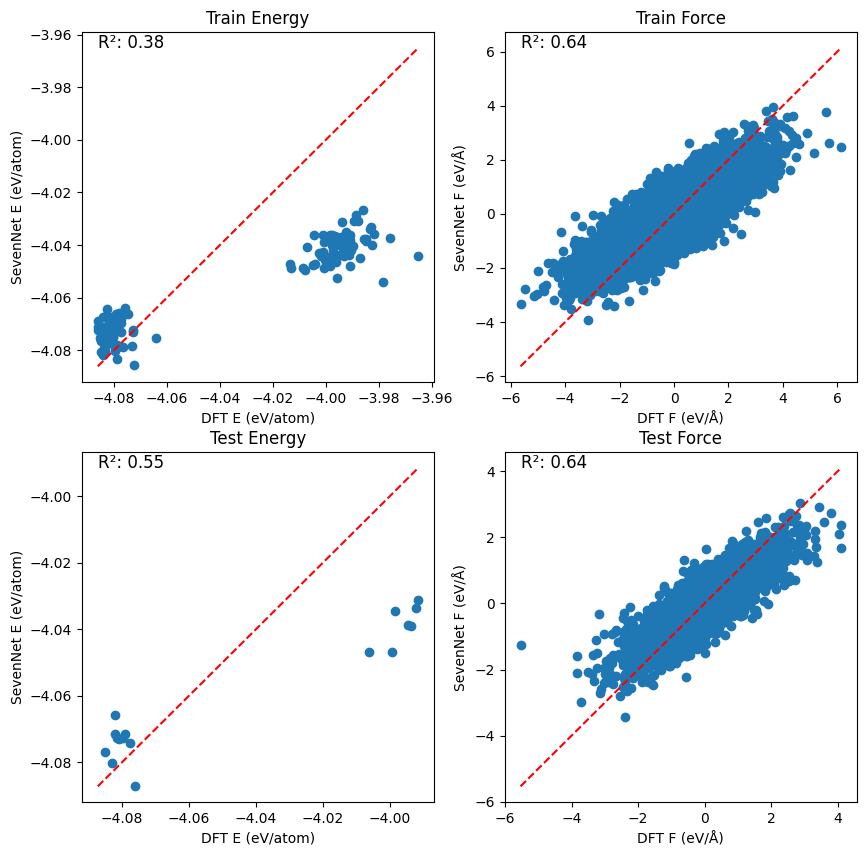

In [12]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

train_ans_energy_np = train_ans_energy.cpu().numpy()
train_pred_energy_np = train_pred_energy.detach().cpu().numpy()
train_ans_force_np = train_ans_force.flatten().cpu().numpy()
train_pred_force_np = train_pred_force.flatten().cpu().numpy()

test_ans_energy_np = test_ans_energy.cpu().numpy()
test_pred_energy_np = test_pred_energy.detach().cpu().numpy()
test_ans_force_np = test_ans_force.flatten().cpu().numpy()
test_pred_force_np = test_pred_force.flatten().cpu().numpy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# train energy plot
ax1.scatter(train_ans_energy_np, train_pred_energy_np)
min_val = min(min(train_ans_energy_np), min(train_pred_energy_np))
max_val = max(max(train_ans_energy_np), max(train_pred_energy_np))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax1.set_xlabel("DFT E (eV/atom)")
ax1.set_ylabel("SevenNet E (eV/atom)")
ax1.set_title("Train Energy")

r2_energy_train = r2_score(train_ans_energy_np, train_pred_energy_np)
ax1.text(min_val, max_val, f"R²: {r2_energy_train:.2f}", fontsize=12)

# train force plot
ax2.scatter(train_ans_force_np, train_pred_force_np)
min_val = min(min(train_ans_force_np), min(train_pred_force_np))
max_val = max(max(train_ans_force_np), max(train_pred_force_np))
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax2.set_xlabel("DFT F (eV/Å)")
ax2.set_ylabel("SevenNet F (eV/Å)")
ax2.set_title("Train Force")

r2_force_train = r2_score(train_ans_force_np, train_pred_force_np)
ax2.text(min_val, max_val, f"R²: {r2_force_train:.2f}", fontsize=12)

# test energy plot
ax3.scatter(test_ans_energy_np, test_pred_energy_np)
min_val = min(min(test_ans_energy_np), min(test_pred_energy_np))
max_val = max(max(test_ans_energy_np), max(test_pred_energy_np))
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax3.set_xlabel("DFT E (eV/atom)")
ax3.set_ylabel("SevenNet E (eV/atom)")
ax3.set_title("Test Energy")

r2_energy_test = r2_score(test_ans_energy_np, test_pred_energy_np)
ax3.text(min_val, max_val, f"R²: {r2_energy_test:.2f}", fontsize=12)

# test force plot
ax4.scatter(test_ans_force_np, test_pred_force_np)
min_val = min(min(test_ans_force_np), min(test_pred_force_np))
max_val = max(max(test_ans_force_np), max(test_pred_force_np))
ax4.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
ax4.set_xlabel("DFT F (eV/Å)")
ax4.set_ylabel("SevenNet F (eV/Å)")
ax4.set_title("Test Force")

r2_force_test = r2_score(test_ans_force_np, test_pred_force_np)
ax4.text(min_val, max_val, f"R²: {r2_force_test:.2f}", fontsize=12)